In [1]:
import math
import dimod
import dwave_networkx as dnx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import *
import minorminer
import networkx as nx
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite

In [2]:
topology_chimera = dnx.chimera_graph(16)
topology_pegasus = dnx.pegasus_graph(16)
topology_zephyr = dnx.zephyr_graph(15)

In [3]:
############### combine curves for a collection of n-values on 1 plot ###############

In [4]:
# ns = [16, 20, 24]
ns = [10, 20, 30, 40, 50]
m = 3
xmax = max(ns)

In [5]:
qubits_chimera = np.zeros((len(ns), xmax))
maxchain_chimera = np.zeros((len(ns), xmax))

for i, n in enumerate(ns):
    degs = range(n)

    for deg in degs:
        G = nx.random_regular_graph(d=deg, n=n)
    
        for j in range(m):
            embedding = minorminer.find_embedding(G, topology_chimera)
            qubits_chimera[i][deg] += sum(map(len, embedding.values()))
            maxchain_chimera[i][deg] += max(map(len, embedding.values()))
        for tensor in [qubits_chimera[i], maxchain_chimera[i]]:
            tensor[deg] /= m
        # print(str(deg) + " done")

nqubits = -0.0982142857142857*deg^2 + 4.348214285714284*deg + 2.8839285714285854
[0.9743817705665777]
nqubits = -0.39367260061919473*deg^2 + 14.32130417956656*deg + -1.1249355005160517
[0.989251800877172]
nqubits = -0.49428971411730016*deg^2 + 24.928481958654352*deg + -9.975248410593322
[0.9859567210528256]
nqubits = -0.5411970675128577*deg^2 + 33.81250683882265*deg + 15.610624794835282
[0.9747143172244709]
nqubits = -0.6002451905831715*deg^2 + 44.9641113198286*deg + 45.338319347165424
[0.9719868796951187]


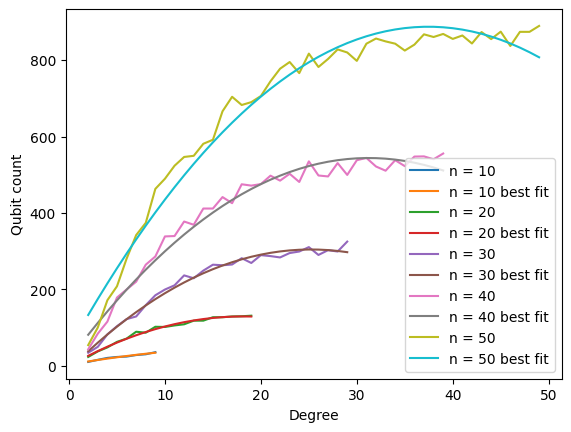

In [13]:
# plot different ns as different curves
leg = [] # legend

for i, n in enumerate(ns):
    # if i < 2:
    #     continue
    degs = range(2, n)
    plt.plot(degs, qubits_chimera[i][2:n])

    # legend
    leg.append("n = " + str(n))
    leg.append("n = " + str(n) + " best fit")

    # fit
    a, b, c = np.polyfit(degs, qubits_chimera[i][2:n], 2)
    chimera_fit = a*degs*degs + b*degs + c
    plt.plot(degs, chimera_fit)
    print("nqubits = " + str(a) + "*deg^2 + " + str(b) + "*deg + " + str(c))
    
    # test correlation
    corr_matrices = [np.corrcoef(qubits_chimera[i][2:n], chimera_fit)]
    corrs = [matrix[0,1] for matrix in corr_matrices]
    R_sq = [corr**2 for corr in corrs]
    print(R_sq)
    
plt.legend(leg)
# plt.title("Qubits required for fixed degree graphs")
plt.xlabel("Degree")
plt.ylabel("Qubit count")

plt.savefig("qubits-fixed-combined-mm.png")

In [5]:
############### random graphs with fixed degree (vary degree) ###############

In [6]:
n = 30
degs = range(n)
m = 3

In [ ]:
# constant n vertices, variable vertex degree deg (Chimera)
qubits_chimera = np.zeros_like(degs)
maxchain_chimera = np.zeros_like(degs)

for deg in degs:
    G = nx.random_regular_graph(d=deg, n=n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[deg] += sum(map(len, embedding.values()))
        maxchain_chimera[deg] += max(map(len, embedding.values()))
    for tensor in [qubits_chimera, maxchain_chimera]:
        tensor[deg] /= m
    print(str(deg) + " done")

In [ ]:
# constant n vertices, variable vertex degree deg (Pegasus)
qubits_pegasus = np.zeros_like(degs)
maxchain_pegasus = np.zeros_like(degs)

for deg in degs:
    G = nx.random_regular_graph(d=deg, n=n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[deg] += sum(map(len, embedding.values()))
        maxchain_pegasus[deg] += max(map(len, embedding.values()))
    for tensor in [qubits_pegasus, maxchain_pegasus]:
        tensor[deg] /= m
    print(str(deg) + " done")

In [ ]:
# constant n vertices, variable vertex degree deg (Zephyr)
qubits_zephyr = np.zeros_like(degs)
maxchain_zephyr = np.zeros_like(degs)

for deg in degs:
    G = nx.random_regular_graph(d=deg, n=n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[deg] += sum(map(len, embedding.values()))
        maxchain_zephyr[deg] += max(map(len, embedding.values()))
    for tensor in [qubits_zephyr, maxchain_zephyr]:
        tensor[deg] /= m
    print(str(deg) + " done")

Text(0, 0.5, 'Qubit count')

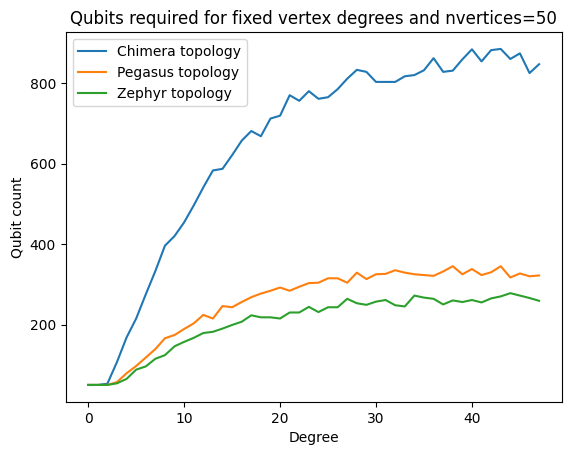

In [8]:
plt.plot(degs, qubits_chimera)
plt.plot(degs, qubits_pegasus)
plt.plot(degs, qubits_zephyr)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.title("Qubits required for fixed vertex degrees and nvertices=50")
plt.xlabel("Degree")
plt.ylabel("Qubit count")
# plt.savefig("qubits-fix-deg.png")

[0.9939919799908459, 0.992158469598866, 0.9878123983014954]


Text(0, 0.5, 'Qubit count')

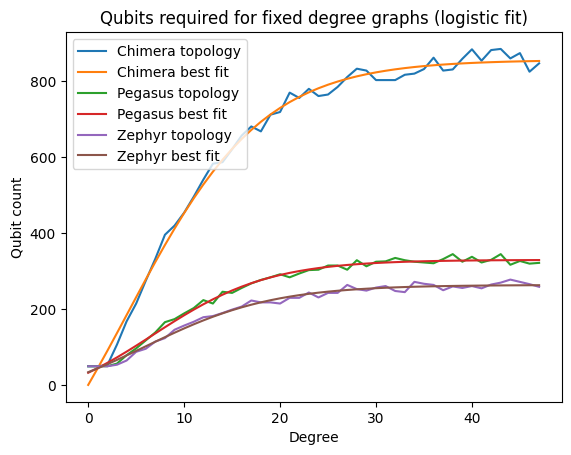

In [11]:
# best fit: S-curve
def logistic(x, L, x_0, k, b):
    return (L / (1 + np.exp(-k * (x - x_0)))) + b

# chimera
L_estimate = qubits_chimera.max()
x_0_estimate = np.median(degs)
k_estimate = 1.0
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_chimera, p_0)
chimera_fit = logistic(degs, *popt)
plt.plot(degs, qubits_chimera)
plt.plot(degs, chimera_fit)
print("Chimera [L, x_0, k, b]:")
print(*popt)

# pegasus
L_estimate = qubits_pegasus.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_pegasus, p_0)
pegasus_fit = logistic(degs, *popt)
plt.plot(degs, qubits_pegasus)
plt.plot(degs, pegasus_fit)
print("Pegasus [L, x_0, k, b]:")
print(*popt)

# zephyr
L_estimate = qubits_zephyr.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, degs, qubits_zephyr, p_0)
zephyr_fit = logistic(degs, *popt)
plt.plot(degs, qubits_zephyr)
plt.plot(degs, zephyr_fit)
print("Zephyr [L, x_0, k, b]:")
print(*popt)

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit), np.corrcoef(qubits_pegasus, pegasus_fit), np.corrcoef(qubits_zephyr, zephyr_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.legend(["Chimera topology", "Chimera best fit", "Pegasus topology", "Pegasus best fit", "Zephyr topology", "Zephyr best fit"])
plt.title("Qubits required for fixed degree graphs (logistic fit)")
plt.xlabel("Degree")
plt.ylabel("Qubit count")

In [26]:
############### random graphs with fixed degree (vary nvariables) ###############

In [ ]:
ns = np.arange(10, 61)
deg = 8
m = 3

qubits_chimera = np.zeros_like(ns)
qubits_pegasus = np.zeros_like(ns)
qubits_zephyr = np.zeros_like(ns)

maxchain_chimera = np.zeros_like(ns)
maxchain_pegasus = np.zeros_like(ns)
maxchain_zephyr = np.zeros_like(ns)

for i, n in enumerate(ns):
    G = nx.random_regular_graph(d=deg, n=n)
    
    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[i] += sum(map(len, embedding.values()))
        maxchain_chimera[i] += max(map(len, embedding.values()))
        
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[i] += sum(map(len, embedding.values()))
        maxchain_pegasus[i] += max(map(len, embedding.values()))

        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[i] += sum(map(len, embedding.values()))
        maxchain_zephyr[i] += max(map(len, embedding.values()))
        
    for tensor in [qubits_chimera, qubits_pegasus, qubits_zephyr, maxchain_chimera, maxchain_pegasus, maxchain_zephyr]:
        tensor[i] /= m
    
    print(str(i) + " done")

nqubits = 0.10634895467621024*n^2 + 2.4777451183666446*n + -4.707488801035624
nqubits = 0.03748320808729885*n^2 + 1.240971813979579*n + 0.46887132211378435
nqubits = 0.028776677579594977*n^2 + 1.1664470490663592*n + -0.41006277692499943
[0.9972184194308762, 0.995436929773989, 0.9968964191779925]


Text(0, 0.5, 'Qubit count')

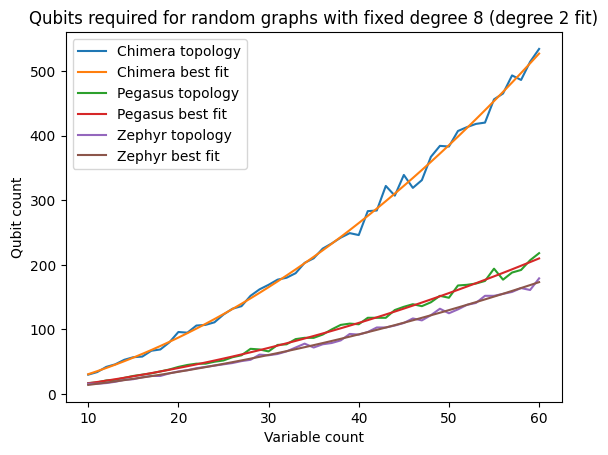

In [36]:
# best fit: degree 2 polynomial

plt.plot(ns, qubits_chimera)
a, b, c = np.polyfit(ns, qubits_chimera, 2)
chimera_fit = a*ns*ns + b*ns + c
plt.plot(ns, chimera_fit)
print("nqubits = " + str(a) + "*n^2 + " + str(b) + "*n + " + str(c))

plt.plot(ns, qubits_pegasus)
a, b, c = np.polyfit(ns, qubits_pegasus, 2)
pegasus_fit = a*ns*ns + b*ns + c
plt.plot(ns, pegasus_fit)
print("nqubits = " + str(a) + "*n^2 + " + str(b) + "*n + " + str(c))

plt.plot(ns, qubits_zephyr)
a, b, c = np.polyfit(ns, qubits_zephyr, 2)
zephyr_fit = a*ns*ns + b*ns + c
plt.plot(ns, zephyr_fit)
print("nqubits = " + str(a) + "*n^2 + " + str(b) + "*n + " + str(c))

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit), np.corrcoef(qubits_pegasus, pegasus_fit), np.corrcoef(qubits_zephyr, zephyr_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.title("Qubits required for random graphs with fixed degree 8 (degree 2 fit)")
plt.legend(["Chimera topology", "Chimera best fit", "Pegasus topology", "Pegasus best fit", "Zephyr topology", "Zephyr best fit"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")
#plt.savefig("qubits-fix_deg-vary_var-fit.png")

In [19]:
# # derivative
# dydx = np.diff(qubits_chimera)/np.diff(degs)
# degs1 = degs[1:len(degs)]
# plt.plot(degs1, dydx)